# Análise Exploratória de Dados (EDA) - Hackathon Forecast 2025

Este notebook realiza a análise exploratória completa dos dados do hackathon, incluindo:
1. Carregamento e inspeção dos três arquivos Parquet
2. Análise das transações como série temporal
3. Identificação de tendências e sazonalidade
4. Análise de distribuições
5. **Análise dos cadastros (PDVs e Produtos)**
6. **Long Tail Analysis**
7. **Cruzamento de dados (Merge)**
8. **Análises por categoria de PDV**
9. **Análises geográficas (Zipcode)**
10. **Insights e recomendações para modelagem**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 1. Carregamento e Inspeção dos Dados

In [2]:
# Carregar os três arquivos Parquet
data_path = '../data/'

# Lista dos arquivos parquet disponíveis
import os
parquet_files = [f for f in os.listdir(data_path) if f.endswith('.parquet')]
print(f"Arquivos encontrados: {len(parquet_files)}")
for file in parquet_files:
    print(f"  - {file}")

# Carregar cada arquivo e identificar sua natureza pelos dados
dataframes = {}
for i, file in enumerate(parquet_files):
    df = pd.read_parquet(os.path.join(data_path, file))
    dataframes[f'df_{i+1}'] = df
    print(f"\n{file}:")
    print(f"  Forma: {df.shape}")
    print(f"  Colunas: {list(df.columns)}")

Arquivos encontrados: 3
  - part-00000-tid-2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36-4-1-c000.snappy.parquet
  - part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet
  - part-00000-tid-7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1-4-1-c000.snappy.parquet

part-00000-tid-2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36-4-1-c000.snappy.parquet:
  Forma: (14419, 4)
  Colunas: ['pdv', 'premise', 'categoria_pdv', 'zipcode']

part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet:
  Forma: (6560698, 11)
  Colunas: ['internal_store_id', 'internal_product_id', 'distributor_id', 'transaction_date', 'reference_date', 'quantity', 'gross_value', 'net_value', 'gross_profit', 'discount', 'taxes']

part-00000-tid-7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1-4-1-c000.snappy.parquet:
  Forma: (7092, 8)
  Colunas: ['produto', 'categoria', 'descricao', 'tipos', 'label', 'subca

In [3]:
# Identificar qual dataset é qual baseado nas colunas
transacoes_df = None
produtos_df = None
pdvs_df = None

for key, df in dataframes.items():
    cols = list(df.columns)
    
    # Identificar transações (maior dataset, com quantity/transaction_date)
    if len(df) > 100000:
        transacoes_df = df
        print(f"\n{key} identificado como TRANSAÇÕES")
        
    # Identificar produtos (tem produto, categoria, marca)
    elif any('produto' in col.lower() for col in cols) or any('categoria' in col.lower() for col in cols):
        produtos_df = df
        print(f"\n{key} identificado como PRODUTOS")
        
    # Identificar PDVs (tem pdv, premise)
    elif any('pdv' in col.lower() for col in cols) or any('premise' in col.lower() for col in cols):
        pdvs_df = df
        print(f"\n{key} identificado como PDVs")

print(f"\n✅ Datasets identificados:")
print(f"  - Transações: {transacoes_df.shape if transacoes_df is not None else 'Não encontrado'}")
print(f"  - Produtos: {produtos_df.shape if produtos_df is not None else 'Não encontrado'}")
print(f"  - PDVs: {pdvs_df.shape if pdvs_df is not None else 'Não encontrado'}")


df_1 identificado como PRODUTOS

df_2 identificado como TRANSAÇÕES

df_3 identificado como PRODUTOS

✅ Datasets identificados:
  - Transações: (6560698, 11)
  - Produtos: (7092, 8)
  - PDVs: Não encontrado


## 2. Inspeção Detalhada dos Datasets

In [4]:
def inspecionar_dataset(df, nome):
    print(f"\n{'='*50}")
    print(f"ANÁLISE DO DATASET: {nome}")
    print(f"{'='*50}")
    
    print(f"\n📊 INFORMAÇÕES GERAIS:")
    print(f"   Forma: {df.shape}")
    print(f"   Colunas: {list(df.columns)}")
    
    print(f"\n🔍 TIPOS DE DADOS E VALORES NULOS:")
    info_df = pd.DataFrame({
        'Tipo': df.dtypes,
        'Nulos': df.isnull().sum(),
        '% Nulos': (df.isnull().sum() / len(df) * 100).round(2),
        'Únicos': df.nunique()
    })
    print(info_df)
    
    print(f"\n📈 ESTATÍSTICAS DESCRITIVAS (Colunas Numéricas):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe())
    else:
        print("   Nenhuma coluna numérica encontrada")
    
    print(f"\n👀 PRIMEIRAS 5 LINHAS:")
    display(df.head())
    
    return info_df

In [5]:
# Analisar cada dataset
if transacoes_df is not None:
    transacoes_info = inspecionar_dataset(transacoes_df, "TRANSAÇÕES")

if produtos_df is not None:
    produtos_info = inspecionar_dataset(produtos_df, "PRODUTOS")

if pdvs_df is not None:
    pdvs_info = inspecionar_dataset(pdvs_df, "PDVs")


ANÁLISE DO DATASET: TRANSAÇÕES

📊 INFORMAÇÕES GERAIS:
   Forma: (6560698, 11)
   Colunas: ['internal_store_id', 'internal_product_id', 'distributor_id', 'transaction_date', 'reference_date', 'quantity', 'gross_value', 'net_value', 'gross_profit', 'discount', 'taxes']

🔍 TIPOS DE DADOS E VALORES NULOS:
                        Tipo  Nulos  % Nulos  Únicos
internal_store_id     object      0      0.0   15086
internal_product_id   object      0      0.0    7092
distributor_id        object      0      0.0       8
transaction_date      object      0      0.0     365
reference_date        object      0      0.0      12
quantity             float64      0      0.0   16449
gross_value          float64      0      0.0  173883
net_value            float64      0      0.0  216337
gross_profit         float64      0      0.0  363451
discount             float64      0      0.0  121528
taxes                float64      0      0.0   12531

📈 ESTATÍSTICAS DESCRITIVAS (Colunas Numéricas):
           

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758



ANÁLISE DO DATASET: PRODUTOS

📊 INFORMAÇÕES GERAIS:
   Forma: (7092, 8)
   Colunas: ['produto', 'categoria', 'descricao', 'tipos', 'label', 'subcategoria', 'marca', 'fabricante']

🔍 TIPOS DE DADOS E VALORES NULOS:
                Tipo  Nulos  % Nulos  Únicos
produto       object      0     0.00    7092
categoria     object      0     0.00       7
descricao     object      0     0.00    7092
tipos         object      0     0.00      22
label         object   1473    20.77      14
subcategoria  object     32     0.45      42
marca         object      0     0.00    4221
fabricante    object      0     0.00     343

📈 ESTATÍSTICAS DESCRITIVAS (Colunas Numéricas):
   Nenhuma coluna numérica encontrada

👀 PRIMEIRAS 5 LINHAS:


,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc


## 3. Análise da Série Temporal de Transações

In [6]:
# Preparar dados de transações para análise temporal
if transacoes_df is not None:
    # Identificar coluna de data
    date_cols = [col for col in transacoes_df.columns if 'date' in col.lower()]
    
    print(f"Colunas de data identificadas: {date_cols}")
    
    if date_cols:
        date_col = 'transaction_date'  # Usar a coluna de transação
        # Converter para datetime se necessário
        if transacoes_df[date_col].dtype != 'datetime64[ns]':
            transacoes_df[date_col] = pd.to_datetime(transacoes_df[date_col], errors='coerce')
        
        print(f"\nUsando coluna de data: {date_col}")
        print(f"Período dos dados: {transacoes_df[date_col].min()} até {transacoes_df[date_col].max()}")
        print(f"Total de dias: {(transacoes_df[date_col].max() - transacoes_df[date_col].min()).days + 1}")
    else:
        print("❌ Não foi possível identificar coluna de data")

Colunas de data identificadas: ['transaction_date', 'reference_date']

Usando coluna de data: transaction_date
Período dos dados: 2022-01-01 00:00:00 até 2022-12-31 00:00:00
Total de dias: 365


In [7]:
# Identificar colunas de quantidade e faturamento
if transacoes_df is not None and date_cols:
    # Definir colunas baseado no que vimos
    qty_col = 'quantity'
    revenue_col = 'gross_value'
    
    print(f"Colunas identificadas:")
    print(f"  Data: {date_col}")
    print(f"  Quantidade: {qty_col}")
    print(f"  Faturamento: {revenue_col}")

Colunas identificadas:
  Data: transaction_date
  Quantidade: quantity
  Faturamento: gross_value


In [8]:
# Agregar dados por dia
if transacoes_df is not None and date_cols:
    daily_data = transacoes_df.groupby(date_col).agg({
        qty_col: ['sum', 'count'],
        revenue_col: 'sum'
    }).round(2)
    
    # Simplificar nomes das colunas
    daily_data.columns = ['Quantidade_Total', 'Num_Transacoes', 'Faturamento_Total']
    daily_data = daily_data.reset_index()
    
    print(f"\n📊 RESUMO DA SÉRIE TEMPORAL DIÁRIA:")
    print(f"   Total de dias com dados: {len(daily_data)}")
    print(f"   Quantidade total vendida: {daily_data['Quantidade_Total'].sum():,.0f}")
    print(f"   Faturamento total: R$ {daily_data['Faturamento_Total'].sum():,.2f}")
    print(f"   Número total de transações: {daily_data['Num_Transacoes'].sum():,.0f}")
    
    print(f"\n📈 ESTATÍSTICAS DIÁRIAS:")
    display(daily_data[['Quantidade_Total', 'Num_Transacoes', 'Faturamento_Total']].describe())
    
    display(daily_data.head(10))


📊 RESUMO DA SÉRIE TEMPORAL DIÁRIA:
   Total de dias com dados: 365
   Quantidade total vendida: 53,311,532
   Faturamento total: R$ 805,333,770.85
   Número total de transações: 6,560,698

📈 ESTATÍSTICAS DIÁRIAS:


,Quantidade_Total,Num_Transacoes,Faturamento_Total
count,3.650000e+02,365.000000,3.650000e+02
mean,1.460590e+05,17974.515068,2.206394e+06
std,1.535171e+06,18872.169406,1.408235e+07
min,4.400000e+02,145.000000,1.139454e+04
25%,8.915000e+03,2378.000000,2.440641e+05
50%,7.246366e+04,20535.000000,1.628263e+06
75%,9.901308e+04,26505.000000,2.233514e+06
max,2.938181e+07,306557.000000,2.698284e+08


,transaction_date,Quantidade_Total,Num_Transacoes,Faturamento_Total
0,2022-01-01,759.00,170,11394.54
1,2022-01-02,3755.75,1112,113119.58
2,2022-01-03,37400.17,8833,847021.86
3,2022-01-04,88379.98,20934,1956602.11
4,2022-01-05,72289.02,18039,1590398.24
5,2022-01-06,58291.91,17456,1276521.45
6,2022-01-07,41230.92,12957,918904.15
7,2022-01-08,1080.00,319,32622.38
8,2022-01-09,5462.89,1601,157364.34
9,2022-01-10,75389.22,22159,1765970.38


## 4. Visualizações da Série Temporal

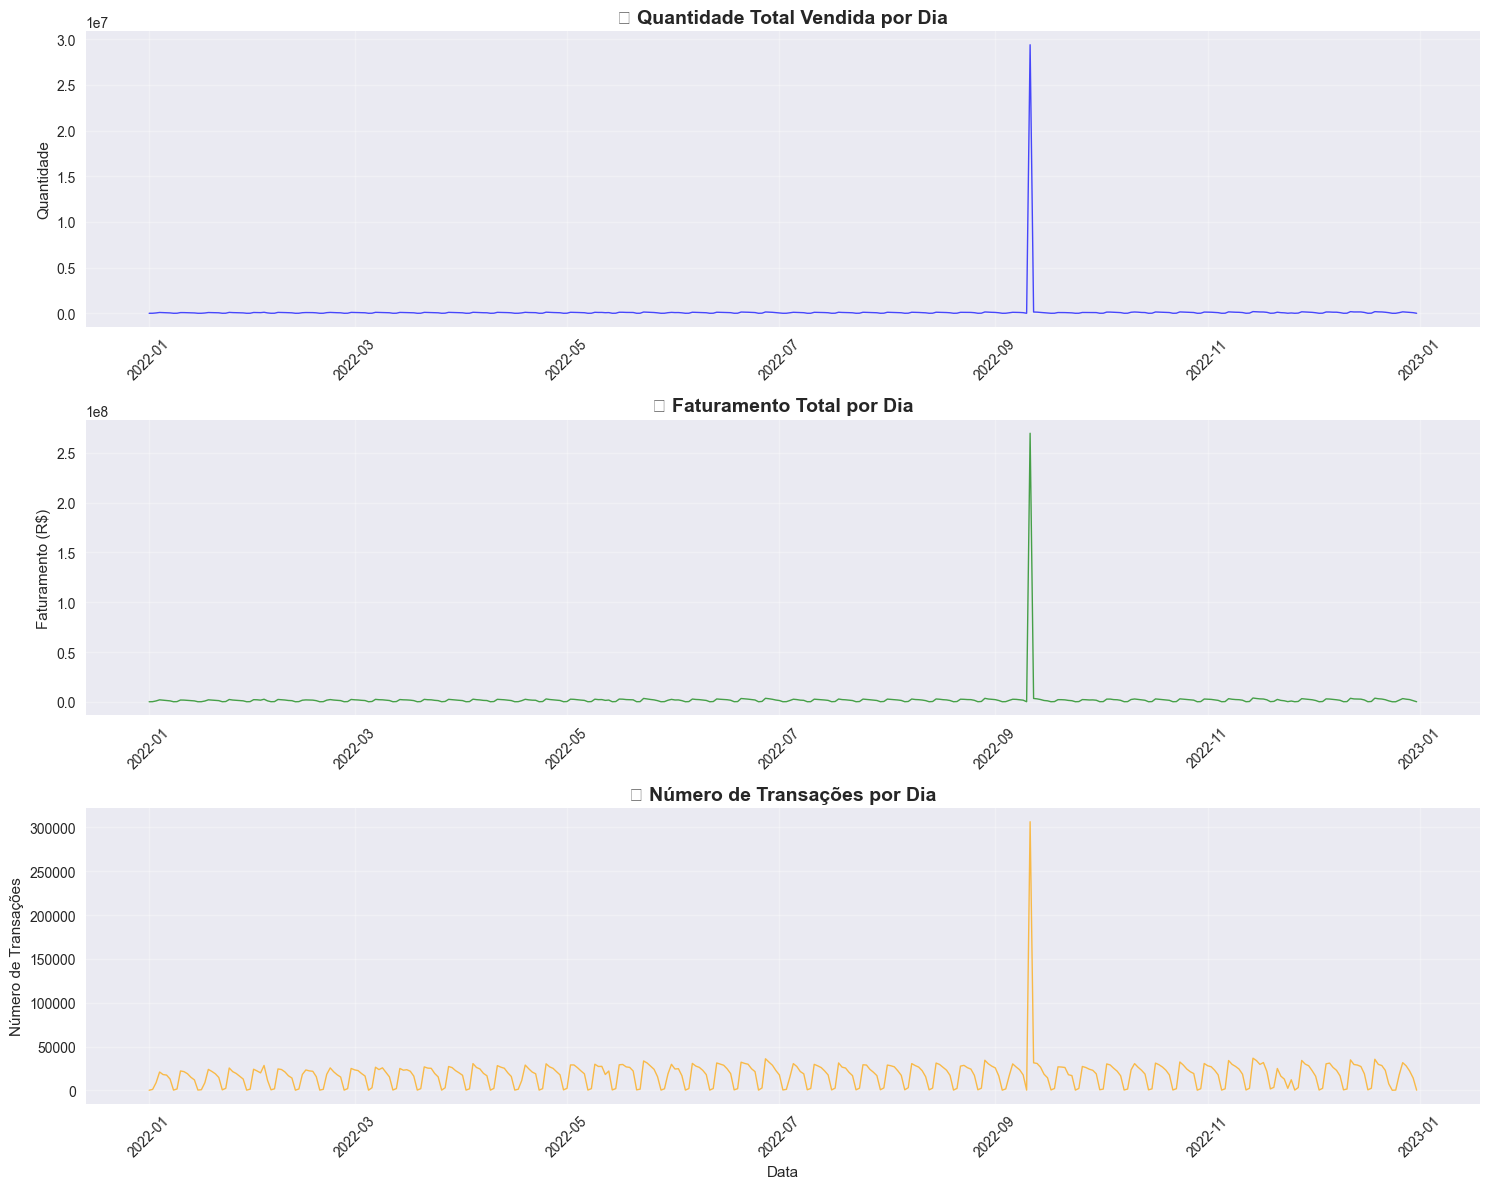

In [9]:
# Plotar série temporal completa
if 'daily_data' in locals():
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Gráfico 1: Quantidade Total por Dia
    axes[0].plot(daily_data[date_col], daily_data['Quantidade_Total'], linewidth=1, alpha=0.7, color='blue')
    axes[0].set_title('📦 Quantidade Total Vendida por Dia', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Quantidade')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Faturamento por Dia
    axes[1].plot(daily_data[date_col], daily_data['Faturamento_Total'], linewidth=1, alpha=0.7, color='green')
    axes[1].set_title('💰 Faturamento Total por Dia', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Faturamento (R$)')
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Gráfico 3: Número de Transações por Dia
    axes[2].plot(daily_data[date_col], daily_data['Num_Transacoes'], linewidth=1, alpha=0.7, color='orange')
    axes[2].set_title('🛒 Número de Transações por Dia', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Número de Transações')
    axes[2].set_xlabel('Data')
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Adicionar médias móveis para identificar tendências
    daily_data['Quantidade_MA7'] = daily_data['Quantidade_Total'].rolling(window=7).mean()
    daily_data['Quantidade_MA30'] = daily_data['Quantidade_Total'].rolling(window=30).mean()
    daily_data['Faturamento_MA7'] = daily_data['Faturamento_Total'].rolling(window=7).mean()
    daily_data['Faturamento_MA30'] = daily_data['Faturamento_Total'].rolling(window=30).mean()

## 5. Análise de Sazonalidade

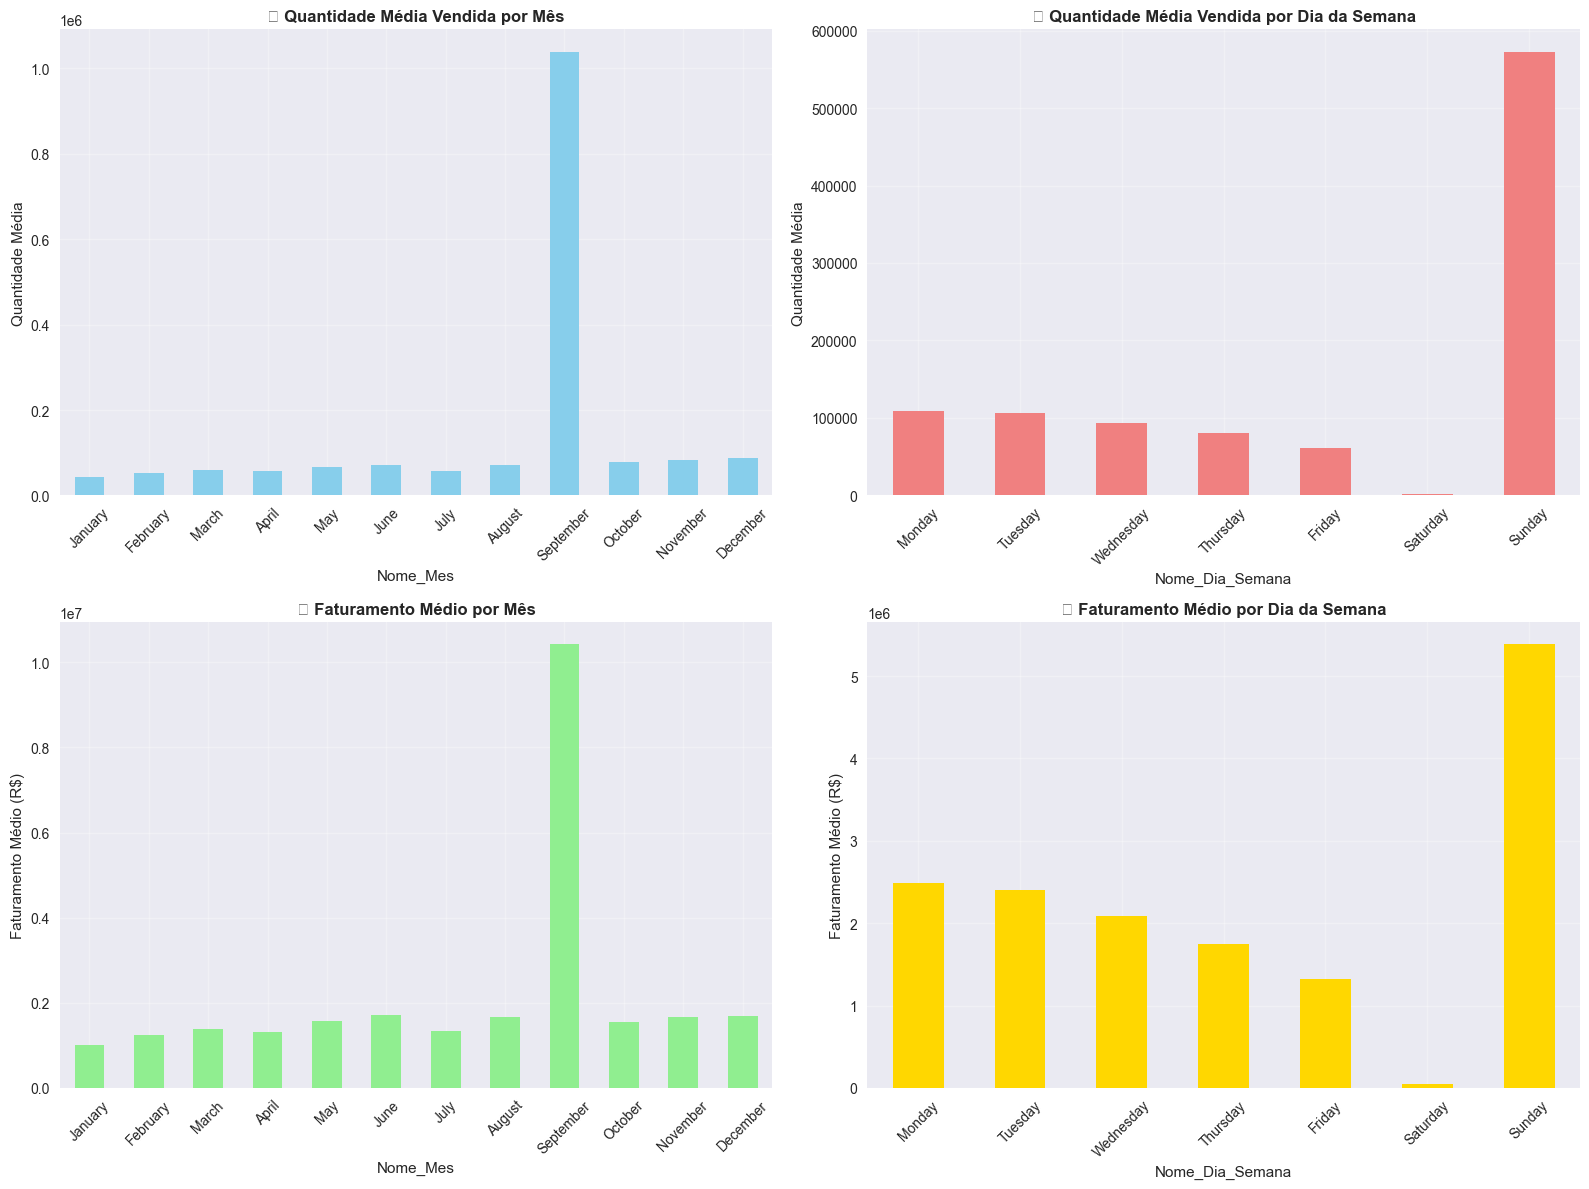

In [10]:
# Análise de sazonalidade
if 'daily_data' in locals():
    # Extrair componentes de data
    daily_data['Ano'] = daily_data[date_col].dt.year
    daily_data['Mes'] = daily_data[date_col].dt.month
    daily_data['Dia_Semana'] = daily_data[date_col].dt.dayofweek  # 0=Segunda, 6=Domingo
    daily_data['Nome_Dia_Semana'] = daily_data[date_col].dt.day_name()
    daily_data['Nome_Mes'] = daily_data[date_col].dt.month_name()
    daily_data['Dia_Mes'] = daily_data[date_col].dt.day
    daily_data['Semana_Ano'] = daily_data[date_col].dt.isocalendar().week
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Vendas por mês
    monthly_sales = daily_data.groupby('Nome_Mes')['Quantidade_Total'].mean()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    monthly_sales = monthly_sales.reindex([m for m in month_order if m in monthly_sales.index])
    
    monthly_sales.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('📅 Quantidade Média Vendida por Mês', fontweight='bold')
    axes[0,0].set_ylabel('Quantidade Média')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Vendas por dia da semana
    weekday_sales = daily_data.groupby('Nome_Dia_Semana')['Quantidade_Total'].mean()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_sales = weekday_sales.reindex([d for d in weekday_order if d in weekday_sales.index])
    
    weekday_sales.plot(kind='bar', ax=axes[0,1], color='lightcoral')
    axes[0,1].set_title('📊 Quantidade Média Vendida por Dia da Semana', fontweight='bold')
    axes[0,1].set_ylabel('Quantidade Média')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Faturamento por mês
    monthly_revenue = daily_data.groupby('Nome_Mes')['Faturamento_Total'].mean()
    monthly_revenue = monthly_revenue.reindex([m for m in month_order if m in monthly_revenue.index])
    
    monthly_revenue.plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('💰 Faturamento Médio por Mês', fontweight='bold')
    axes[1,0].set_ylabel('Faturamento Médio (R$)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Faturamento por dia da semana
    weekday_revenue = daily_data.groupby('Nome_Dia_Semana')['Faturamento_Total'].mean()
    weekday_revenue = weekday_revenue.reindex([d for d in weekday_order if d in weekday_revenue.index])
    
    weekday_revenue.plot(kind='bar', ax=axes[1,1], color='gold')
    axes[1,1].set_title('💸 Faturamento Médio por Dia da Semana', fontweight='bold')
    axes[1,1].set_ylabel('Faturamento Médio (R$)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Agregação para Dados Semanais

📅 DADOS SEMANAIS AGREGADOS
Total de semanas: 53
Período: 2021-12-27 até 2022-12-26

📊 ESTATÍSTICAS SEMANAIS:


,Quantidade_Total,Faturamento_Total,Num_Transacoes
count,5.300000e+01,5.300000e+01,53.000000
mean,1.005878e+06,1.519498e+07,123786.754717
std,4.034057e+06,3.712400e+07,47488.869715
min,4.514750e+03,1.245141e+05,1282.000000
25%,3.897460e+05,9.116723e+06,113876.000000
50%,4.390531e+05,1.040007e+07,124157.000000
75%,5.482049e+05,1.139995e+07,129168.000000
max,2.980724e+07,2.798773e+08,421668.000000


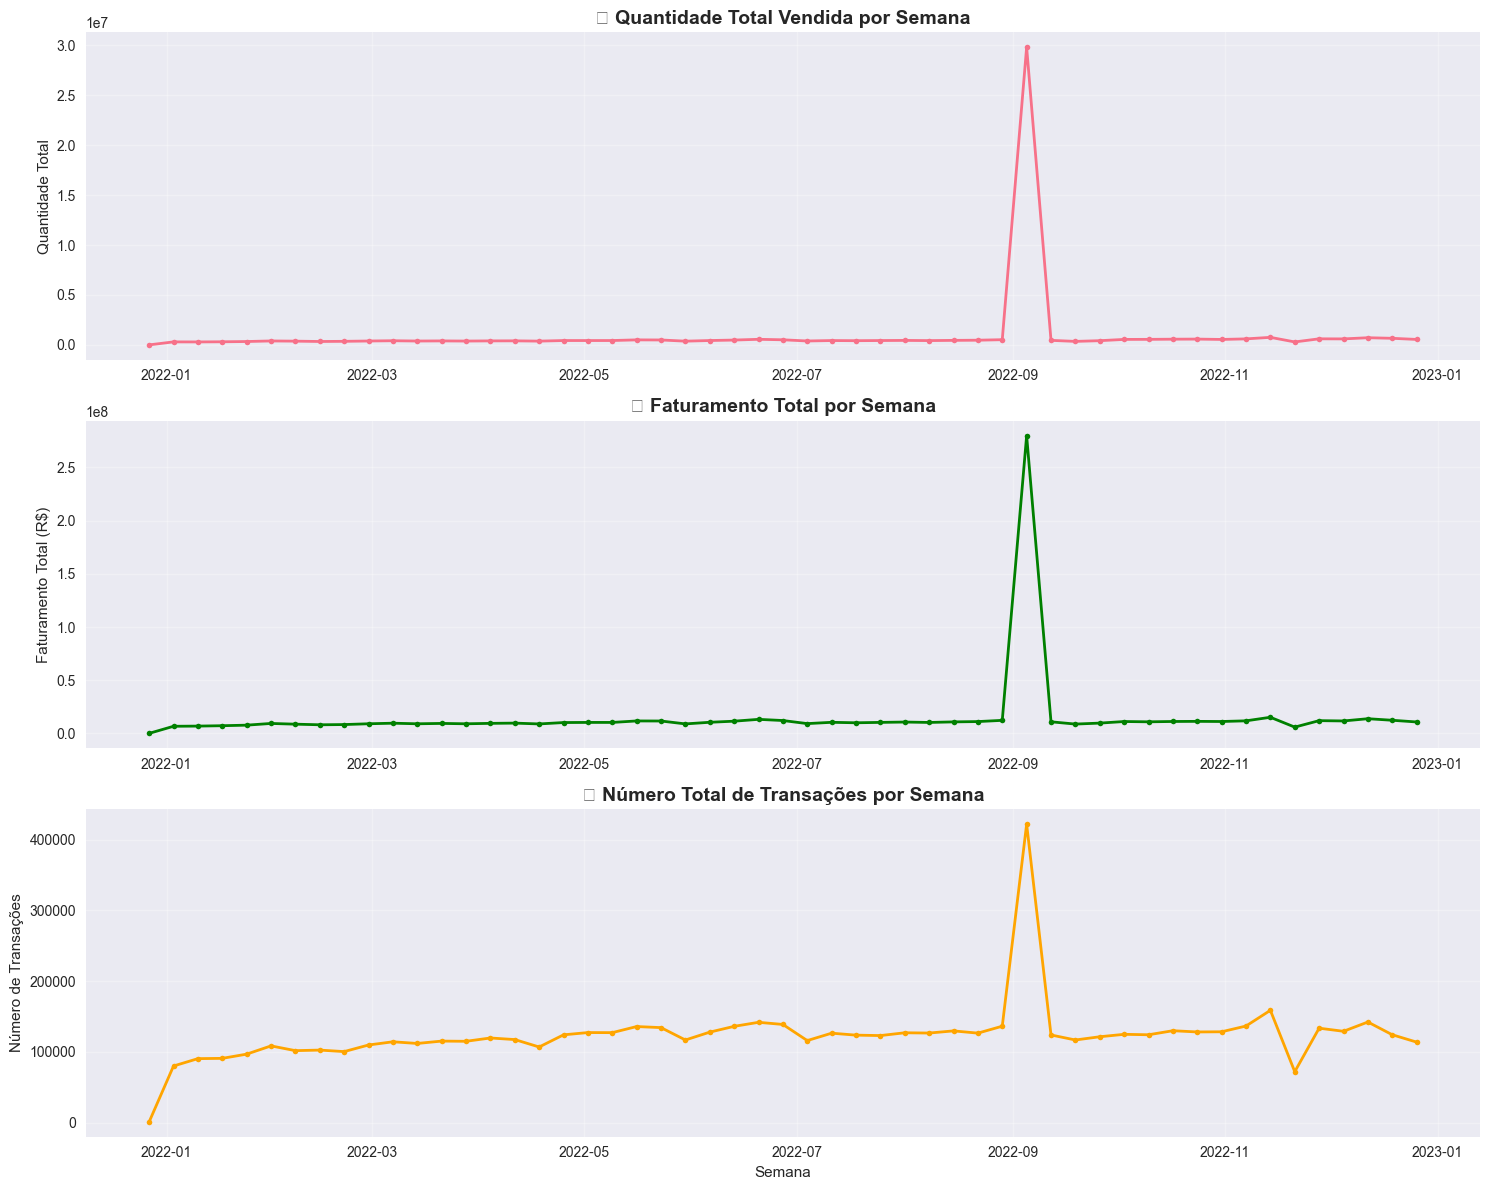


👀 PRIMEIRAS 10 SEMANAS:


,Semana,Quantidade_Total,Faturamento_Total,Num_Transacoes
0,2021-12-27,4514.75,124514.12,1282
1,2022-01-03,304134.89,6779434.53,80139
2,2022-01-10,299457.54,6948379.07,90539
3,2022-01-17,314141.12,7310809.58,90939
4,2022-01-24,340102.16,7824493.84,96884
5,2022-01-31,397676.73,9437003.87,108538
6,2022-02-07,377080.04,8757261.09,101837
7,2022-02-14,343559.12,8183786.82,102619
8,2022-02-21,359780.35,8393949.50,100481
9,2022-02-28,391468.60,9136140.48,109796



👀 ÚLTIMAS 10 SEMANAS:


,Semana,Quantidade_Total,Faturamento_Total,Num_Transacoes
43,2022-10-24,583604.25,11399950.60,128223
44,2022-10-31,548204.89,11263805.77,128477
45,2022-11-07,604987.97,11897917.95,136594
46,2022-11-14,758090.74,15237253.78,158780
47,2022-11-21,298678.23,5995621.43,72100
48,2022-11-28,611053.98,12064754.90,133541
49,2022-12-05,602815.11,11786513.15,129168
50,2022-12-12,720122.62,13886481.87,142262
51,2022-12-19,663243.93,12430208.53,124282
52,2022-12-26,549422.54,10829050.52,113876


In [11]:
# Como o objetivo é prever vendas semanais, vamos agregar os dados
if 'daily_data' in locals():
    # Criar dados semanais
    daily_data['Semana'] = daily_data[date_col].dt.to_period('W').dt.start_time
    
    weekly_data = daily_data.groupby('Semana').agg({
        'Quantidade_Total': 'sum',
        'Faturamento_Total': 'sum',
        'Num_Transacoes': 'sum'
    }).reset_index()
    
    print(f"📅 DADOS SEMANAIS AGREGADOS")
    print(f"=" * 40)
    print(f"Total de semanas: {len(weekly_data)}")
    print(f"Período: {weekly_data['Semana'].min().strftime('%Y-%m-%d')} até {weekly_data['Semana'].max().strftime('%Y-%m-%d')}")
    
    print(f"\n📊 ESTATÍSTICAS SEMANAIS:")
    display(weekly_data[['Quantidade_Total', 'Faturamento_Total', 'Num_Transacoes']].describe())
    
    # Visualizar dados semanais
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    axes[0].plot(weekly_data['Semana'], weekly_data['Quantidade_Total'], marker='o', linewidth=2, markersize=4)
    axes[0].set_title('📦 Quantidade Total Vendida por Semana', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Quantidade Total')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(weekly_data['Semana'], weekly_data['Faturamento_Total'], marker='o', linewidth=2, markersize=4, color='green')
    axes[1].set_title('💰 Faturamento Total por Semana', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Faturamento Total (R$)')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(weekly_data['Semana'], weekly_data['Num_Transacoes'], marker='o', linewidth=2, markersize=4, color='orange')
    axes[2].set_title('🛒 Número Total de Transações por Semana', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Número de Transações')
    axes[2].set_xlabel('Semana')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar algumas semanas
    print(f"\n👀 PRIMEIRAS 10 SEMANAS:")
    display(weekly_data.head(10))
    
    print(f"\n👀 ÚLTIMAS 10 SEMANAS:")
    display(weekly_data.tail(10))

## 7. Análise dos Cadastros (Enriquecimento)

Agora vamos analisar os dados cadastrais de PDVs e Produtos para entender melhor o negócio.

In [12]:
# Análise detalhada dos PDVs
print("🏪 ANÁLISE DOS PONTOS DE VENDA (PDVs)")
print("=" * 50)

if pdvs_df is not None:
    print(f"\n📊 RESUMO GERAL:")
    print(f"   • Total de PDVs: {len(pdvs_df):,}")
    print(f"   • Colunas: {list(pdvs_df.columns)}")
    
    # Distribuição por Premise (On/Off)
    print(f"\n🏢 DISTRIBUIÇÃO POR TIPO DE PREMISE:")
    premise_dist = pdvs_df['premise'].value_counts()
    premise_pct = pdvs_df['premise'].value_counts(normalize=True) * 100
    
    for premise, count in premise_dist.items():
        print(f"   • {premise}: {count:,} ({premise_pct[premise]:.1f}%)")
    
    # Distribuição por Categoria de PDV
    print(f"\n🏷️ DISTRIBUIÇÃO POR CATEGORIA DE PDV:")
    categoria_dist = pdvs_df['categoria_pdv'].value_counts().head(15)  # Top 15
    categoria_pct = pdvs_df['categoria_pdv'].value_counts(normalize=True) * 100
    
    for i, (categoria, count) in enumerate(categoria_dist.items()):
        print(f"   {i+1:2d}. {categoria}: {count:,} ({categoria_pct[categoria]:.1f}%)")
    
    # Distribuição geográfica (Zipcode)
    print(f"\n🗺️ DISTRIBUIÇÃO GEOGRÁFICA:")
    zipcode_stats = pdvs_df['zipcode'].describe()
    print(f"   • Zipcodes únicos: {pdvs_df['zipcode'].nunique():,}")
    print(f"   • Zipcode médio: {zipcode_stats['mean']:.0f}")
    print(f"   • Range: {zipcode_stats['min']:.0f} - {zipcode_stats['max']:.0f}")
    
    # Top zipcodes com mais PDVs
    print(f"\n🏆 TOP 10 ZIPCODES COM MAIS PDVs:")
    top_zipcodes = pdvs_df['zipcode'].value_counts().head(10)
    for zipcode, count in top_zipcodes.items():
        print(f"   • {zipcode}: {count:,} PDVs")

    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfico 1: Distribuição por Premise
    premise_dist.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('🏢 Distribuição de PDVs por Tipo de Premise', fontweight='bold')
    axes[0,0].set_ylabel('')
    
    # Gráfico 2: Top 15 Categorias de PDV
    categoria_dist.head(15).plot(kind='barh', ax=axes[0,1], color='skyblue')
    axes[0,1].set_title('🏷️ Top 15 Categorias de PDV', fontweight='bold')
    axes[0,1].set_xlabel('Número de PDVs')
    
    # Gráfico 3: Distribuição de Zipcodes
    axes[1,0].hist(pdvs_df['zipcode'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1,0].set_title('🗺️ Distribuição de Zipcodes', fontweight='bold')
    axes[1,0].set_xlabel('Zipcode')
    axes[1,0].set_ylabel('Número de PDVs')
    
    # Gráfico 4: Top 10 Zipcodes
    top_zipcodes.plot(kind='bar', ax=axes[1,1], color='lightgreen')
    axes[1,1].set_title('🏆 Top 10 Zipcodes com Mais PDVs', fontweight='bold')
    axes[1,1].set_ylabel('Número de PDVs')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

🏪 ANÁLISE DOS PONTOS DE VENDA (PDVs)



🍺 ANÁLISE DOS PRODUTOS

📊 RESUMO GERAL:
   • Total de produtos: 7,092
   • Colunas: ['produto', 'categoria', 'descricao', 'tipos', 'label', 'subcategoria', 'marca', 'fabricante']

🏷️ DISTRIBUIÇÃO POR CATEGORIA:
   • Distilled Spirits: 2,202 (31.0%)
   • Wine: 1,879 (26.5%)
   • Package: 1,403 (19.8%)
   • Draft: 918 (12.9%)
   • Non-Alcohol: 597 (8.4%)
   • ABA Spirits: 91 (1.3%)
   • Tobacco: 2 (0.0%)

📂 TOP 15 SUBCATEGORIAS:
    1. Red Wine: 989 (14.0%)
    2. White Wine: 569 (8.1%)
    3. Lager: 404 (5.7%)
    4. Other Package: 390 (5.5%)
    5. Liqueurs & Cordials: 374 (5.3%)
    6. Other Spirits: 337 (4.8%)
    7. Bourbon Whiskey: 321 (4.5%)
    8. Pale Ale: 262 (3.7%)
    9. IPA: 262 (3.7%)
   10. Ready-to-Drink: 228 (3.2%)
   11. Tequila / Mezcal: 211 (3.0%)
   12. Vodka: 202 (2.9%)
   13. Rum: 180 (2.5%)
   14. Stout & Porter: 170 (2.4%)
   15. Other Draft: 162 (2.3%)

🏭 ANÁLISE DE MARCAS:
   • Total de marcas únicas: 4,221

🏆 TOP 15 MARCAS COM MAIS PRODUTOS:
    1. Barrell Bo

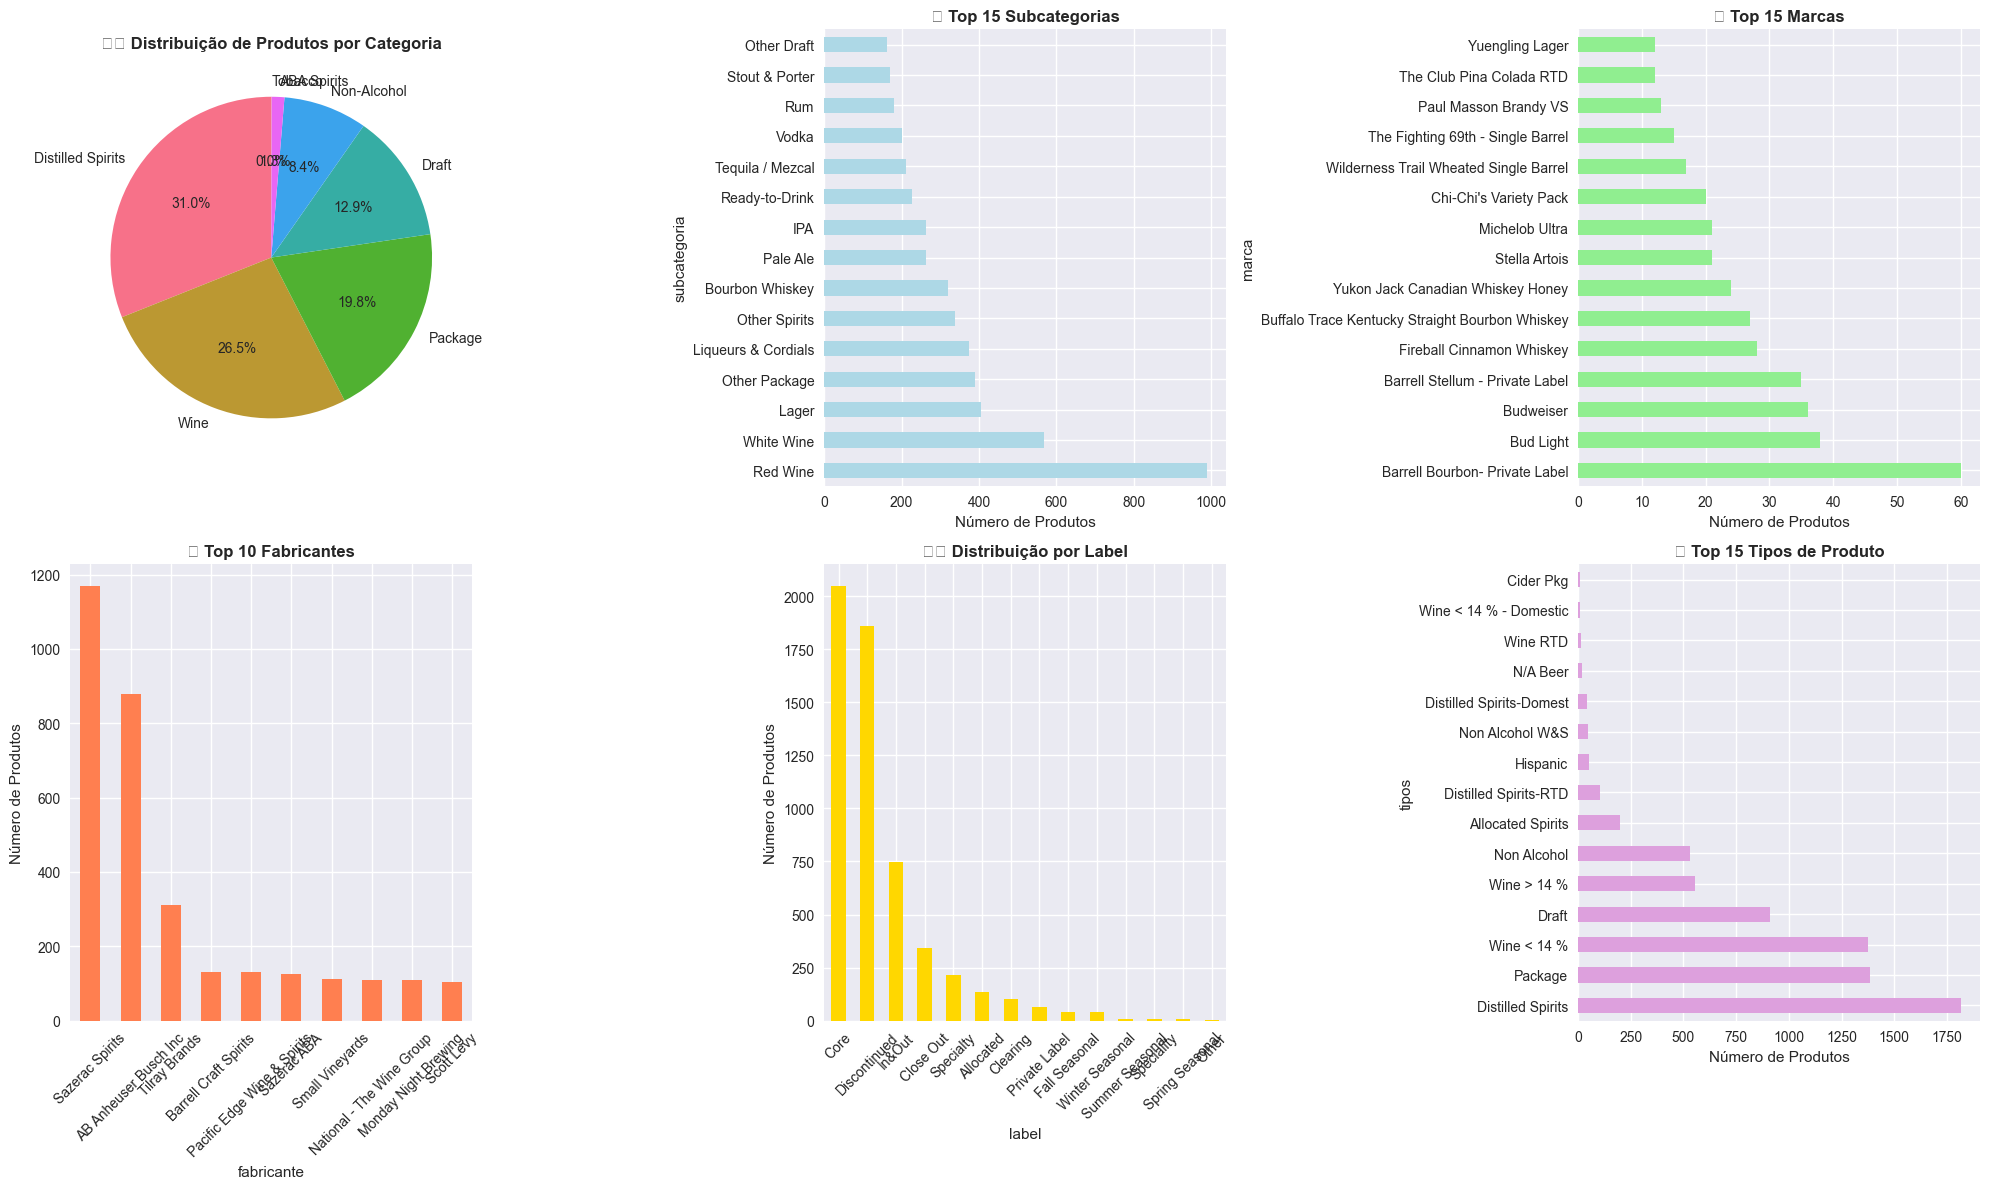

In [13]:
# Análise detalhada dos Produtos
print("\n🍺 ANÁLISE DOS PRODUTOS")
print("=" * 50)

if produtos_df is not None:
    print(f"\n📊 RESUMO GERAL:")
    print(f"   • Total de produtos: {len(produtos_df):,}")
    print(f"   • Colunas: {list(produtos_df.columns)}")
    
    # Distribuição por Categoria
    print(f"\n🏷️ DISTRIBUIÇÃO POR CATEGORIA:")
    categoria_prod_dist = produtos_df['categoria'].value_counts()
    categoria_prod_pct = produtos_df['categoria'].value_counts(normalize=True) * 100
    
    for categoria, count in categoria_prod_dist.items():
        print(f"   • {categoria}: {count:,} ({categoria_prod_pct[categoria]:.1f}%)")
    
    # Distribuição por Subcategoria (Top 15)
    print(f"\n📂 TOP 15 SUBCATEGORIAS:")
    subcategoria_dist = produtos_df['subcategoria'].value_counts().head(15)
    subcategoria_pct = produtos_df['subcategoria'].value_counts(normalize=True) * 100
    
    for i, (subcat, count) in enumerate(subcategoria_dist.items()):
        if pd.notna(subcat):  # Ignorar valores NaN
            print(f"   {i+1:2d}. {subcat}: {count:,} ({subcategoria_pct[subcat]:.1f}%)")
    
    # Análise de Marcas
    print(f"\n🏭 ANÁLISE DE MARCAS:")
    print(f"   • Total de marcas únicas: {produtos_df['marca'].nunique():,}")
    
    print(f"\n🏆 TOP 15 MARCAS COM MAIS PRODUTOS:")
    top_marcas = produtos_df['marca'].value_counts().head(15)
    marca_pct = produtos_df['marca'].value_counts(normalize=True) * 100
    
    for i, (marca, count) in enumerate(top_marcas.items()):
        print(f"   {i+1:2d}. {marca}: {count:,} ({marca_pct[marca]:.2f}%)")
    
    # Análise de Fabricantes
    print(f"\n🏭 ANÁLISE DE FABRICANTES:")
    print(f"   • Total de fabricantes únicos: {produtos_df['fabricante'].nunique():,}")
    
    print(f"\n🏆 TOP 10 FABRICANTES COM MAIS PRODUTOS:")
    top_fabricantes = produtos_df['fabricante'].value_counts().head(10)
    fabricante_pct = produtos_df['fabricante'].value_counts(normalize=True) * 100
    
    for i, (fabricante, count) in enumerate(top_fabricantes.items()):
        print(f"   {i+1:2d}. {fabricante}: {count:,} ({fabricante_pct[fabricante]:.2f}%)")
    
    # Análise do campo Label
    print(f"\n🏷️ DISTRIBUIÇÃO POR LABEL:")
    if produtos_df['label'].notna().sum() > 0:
        label_dist = produtos_df['label'].value_counts()
        label_pct = produtos_df['label'].value_counts(normalize=True) * 100
        
        for label, count in label_dist.items():
            print(f"   • {label}: {count:,} ({label_pct[label]:.1f}%)")
        
        missing_labels = produtos_df['label'].isna().sum()
        print(f"   • Missing/NaN: {missing_labels:,} ({missing_labels/len(produtos_df)*100:.1f}%)")
    
    # Visualizações
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Gráfico 1: Distribuição por Categoria
    categoria_prod_dist.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
    axes[0,0].set_title('🏷️ Distribuição de Produtos por Categoria', fontweight='bold')
    axes[0,0].set_ylabel('')
    
    # Gráfico 2: Top 15 Subcategorias
    subcategoria_dist.head(15).plot(kind='barh', ax=axes[0,1], color='lightblue')
    axes[0,1].set_title('📂 Top 15 Subcategorias', fontweight='bold')
    axes[0,1].set_xlabel('Número de Produtos')
    
    # Gráfico 3: Top 15 Marcas
    top_marcas.head(15).plot(kind='barh', ax=axes[0,2], color='lightgreen')
    axes[0,2].set_title('🏆 Top 15 Marcas', fontweight='bold')
    axes[0,2].set_xlabel('Número de Produtos')
    
    # Gráfico 4: Top 10 Fabricantes
    top_fabricantes.plot(kind='bar', ax=axes[1,0], color='coral')
    axes[1,0].set_title('🏭 Top 10 Fabricantes', fontweight='bold')
    axes[1,0].set_ylabel('Número de Produtos')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Gráfico 5: Distribuição de Labels
    if produtos_df['label'].notna().sum() > 0:
        label_dist.plot(kind='bar', ax=axes[1,1], color='gold')
        axes[1,1].set_title('🏷️ Distribuição por Label', fontweight='bold')
        axes[1,1].set_ylabel('Número de Produtos')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    # Gráfico 6: Distribuição por Tipos
    tipos_dist = produtos_df['tipos'].value_counts().head(15)
    tipos_dist.plot(kind='barh', ax=axes[1,2], color='plum')
    axes[1,2].set_title('📦 Top 15 Tipos de Produto', fontweight='bold')
    axes[1,2].set_xlabel('Número de Produtos')
    
    plt.tight_layout()
    plt.show()

## 8. Análise de Long Tail (Distribuição 80/20)


📊 ANÁLISE DE LONG TAIL (Distribuição 80/20)

🏭 LONG TAIL - MARCAS:
   • Total de marcas: 4,221
   • Top 2802 marcas representam 80% dos produtos (5,673 produtos)
   • Concentração: 66.4% das marcas = 80% dos produtos
   • Marcas com apenas 1 produto: 2,824 (66.9%)

🏷️ LONG TAIL - CATEGORIAS:
   • Total de categorias: 7
   1. Distilled Spirits: 2,202 produtos (31.0%)
   2. Wine: 1,879 produtos (26.5%)
   3. Package: 1,403 produtos (19.8%)
   4. Draft: 918 produtos (12.9%)
   5. Non-Alcohol: 597 produtos (8.4%)
   6. ABA Spirits: 91 produtos (1.3%)
   7. Tobacco: 2 produtos (0.0%)

🏭 LONG TAIL - FABRICANTES:
   • Total de fabricantes: 343
   • Top 86 fabricantes representam 80% dos produtos
   • Concentração: 25.1% dos fabricantes = 80% dos produtos
   • Fabricantes com apenas 1 produto: 40 (11.7%)


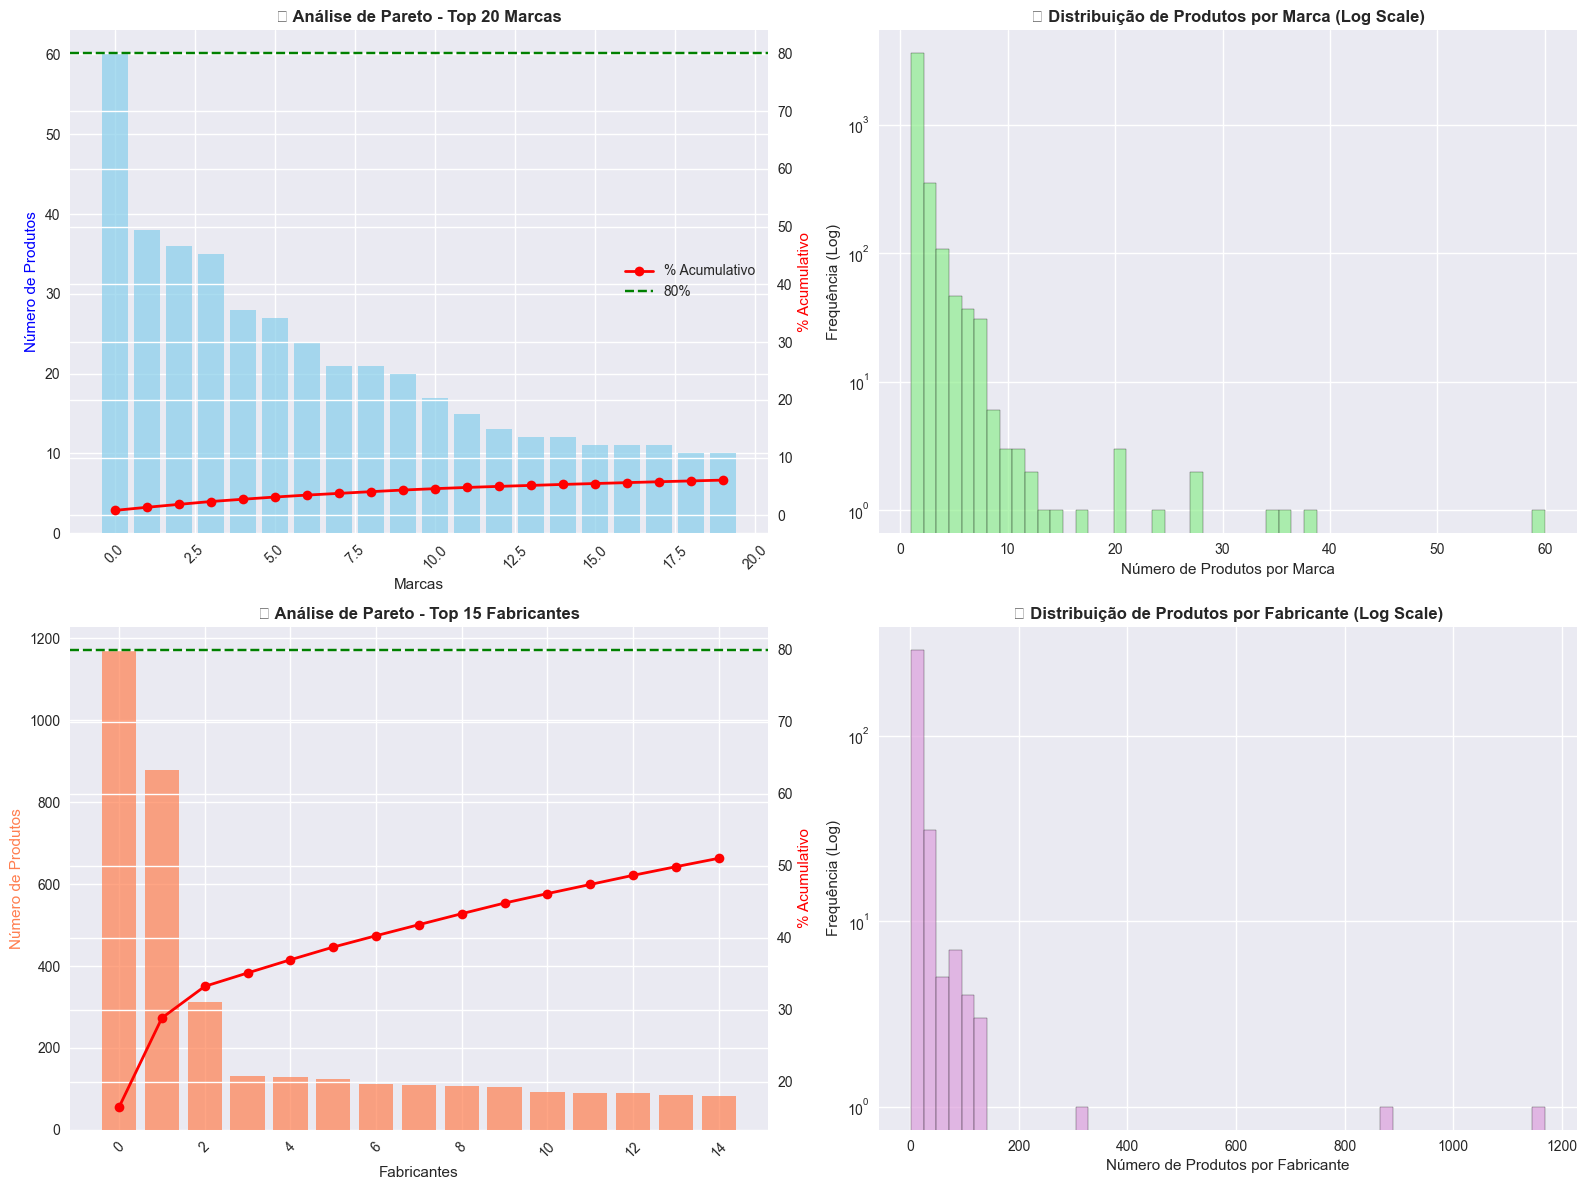

In [14]:
# Análise de Long Tail - Marcas e Categorias
print("\n📊 ANÁLISE DE LONG TAIL (Distribuição 80/20)")
print("=" * 50)

if produtos_df is not None:
    # Análise Long Tail - Marcas
    print(f"\n🏭 LONG TAIL - MARCAS:")
    marca_counts = produtos_df['marca'].value_counts()
    total_produtos = len(produtos_df)
    
    # Calcular percentuais acumulativos
    marca_cumsum = marca_counts.cumsum()
    marca_cumsum_pct = (marca_cumsum / total_produtos) * 100
    
    # Encontrar quantas marcas representam 80% dos produtos
    marcas_80pct = (marca_cumsum_pct <= 80).sum()
    produtos_80pct = marca_cumsum.iloc[marcas_80pct-1] if marcas_80pct > 0 else 0
    
    print(f"   • Total de marcas: {len(marca_counts):,}")
    print(f"   • Top {marcas_80pct} marcas representam 80% dos produtos ({produtos_80pct:,} produtos)")
    print(f"   • Concentração: {marcas_80pct/len(marca_counts)*100:.1f}% das marcas = 80% dos produtos")
    
    # Marcas com apenas 1 produto (cauda longa)
    marcas_1produto = (marca_counts == 1).sum()
    print(f"   • Marcas com apenas 1 produto: {marcas_1produto:,} ({marcas_1produto/len(marca_counts)*100:.1f}%)")
    
    # Análise Long Tail - Categorias  
    print(f"\n🏷️ LONG TAIL - CATEGORIAS:")
    categoria_counts = produtos_df['categoria'].value_counts()
    
    print(f"   • Total de categorias: {len(categoria_counts):,}")
    for i, (categoria, count) in enumerate(categoria_counts.items()):
        pct = count / total_produtos * 100
        print(f"   {i+1}. {categoria}: {count:,} produtos ({pct:.1f}%)")
    
    # Análise Long Tail - Fabricantes
    print(f"\n🏭 LONG TAIL - FABRICANTES:")
    fabricante_counts = produtos_df['fabricante'].value_counts()
    
    # Calcular percentuais acumulativos para fabricantes
    fabricante_cumsum = fabricante_counts.cumsum()
    fabricante_cumsum_pct = (fabricante_cumsum / total_produtos) * 100
    
    # Encontrar quantos fabricantes representam 80% dos produtos
    fabricantes_80pct = (fabricante_cumsum_pct <= 80).sum()
    
    print(f"   • Total de fabricantes: {len(fabricante_counts):,}")
    print(f"   • Top {fabricantes_80pct} fabricantes representam 80% dos produtos")
    print(f"   • Concentração: {fabricantes_80pct/len(fabricante_counts)*100:.1f}% dos fabricantes = 80% dos produtos")
    
    # Fabricantes com apenas 1 produto
    fabricantes_1produto = (fabricante_counts == 1).sum()
    print(f"   • Fabricantes com apenas 1 produto: {fabricantes_1produto:,} ({fabricantes_1produto/len(fabricante_counts)*100:.1f}%)")
    
    # Visualizações Long Tail
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfico 1: Pareto - Top 20 Marcas
    top20_marcas = marca_counts.head(20)
    pareto_data = pd.DataFrame({
        'Marcas': top20_marcas.values,
        'Cumsum_Pct': (top20_marcas.cumsum() / total_produtos * 100).values
    }, index=top20_marcas.index)
    
    ax1 = axes[0,0]
    ax1_twin = ax1.twinx()
    
    bars = ax1.bar(range(len(top20_marcas)), pareto_data['Marcas'], alpha=0.7, color='skyblue')
    line = ax1_twin.plot(range(len(top20_marcas)), pareto_data['Cumsum_Pct'], 'ro-', color='red', linewidth=2)
    
    ax1.set_title('📊 Análise de Pareto - Top 20 Marcas', fontweight='bold')
    ax1.set_xlabel('Marcas')
    ax1.set_ylabel('Número de Produtos', color='blue')
    ax1_twin.set_ylabel('% Acumulativo', color='red')
    ax1.tick_params(axis='x', rotation=45)
    ax1_twin.axhline(y=80, color='green', linestyle='--', label='80%')
    ax1_twin.legend(['% Acumulativo', '80%'])
    
    # Gráfico 2: Distribuição de Produtos por Marca (Log Scale)
    axes[0,1].hist(marca_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_yscale('log')
    axes[0,1].set_title('📈 Distribuição de Produtos por Marca (Log Scale)', fontweight='bold')
    axes[0,1].set_xlabel('Número de Produtos por Marca')
    axes[0,1].set_ylabel('Frequência (Log)')
    
    # Gráfico 3: Pareto - Top 15 Fabricantes
    top15_fabricantes = fabricante_counts.head(15)
    pareto_fab_data = pd.DataFrame({
        'Fabricantes': top15_fabricantes.values,
        'Cumsum_Pct': (top15_fabricantes.cumsum() / total_produtos * 100).values
    }, index=top15_fabricantes.index)
    
    ax3 = axes[1,0]
    ax3_twin = ax3.twinx()
    
    bars3 = ax3.bar(range(len(top15_fabricantes)), pareto_fab_data['Fabricantes'], alpha=0.7, color='coral')
    line3 = ax3_twin.plot(range(len(top15_fabricantes)), pareto_fab_data['Cumsum_Pct'], 'ro-', color='red', linewidth=2)
    
    ax3.set_title('🏭 Análise de Pareto - Top 15 Fabricantes', fontweight='bold')
    ax3.set_xlabel('Fabricantes')
    ax3.set_ylabel('Número de Produtos', color='coral')
    ax3_twin.set_ylabel('% Acumulativo', color='red')
    ax3.tick_params(axis='x', rotation=45)
    ax3_twin.axhline(y=80, color='green', linestyle='--')
    
    # Gráfico 4: Distribuição de Produtos por Fabricante (Log Scale)
    axes[1,1].hist(fabricante_counts, bins=50, alpha=0.7, color='plum', edgecolor='black')
    axes[1,1].set_yscale('log')
    axes[1,1].set_title('📈 Distribuição de Produtos por Fabricante (Log Scale)', fontweight='bold')
    axes[1,1].set_xlabel('Número de Produtos por Fabricante')
    axes[1,1].set_ylabel('Frequência (Log)')
    
    plt.tight_layout()
    plt.show()

## 9. Cruzamento de Dados (Merge dos DataFrames)

Agora vamos fazer o merge dos dados de transações com PDVs e produtos para análises mais profundas.

In [15]:
# Merge dos DataFrames
print("🔗 REALIZANDO MERGE DOS DADOS")
print("=" * 50)

# Primeiro, vamos identificar as chaves de join corretas
print(f"\n🔍 IDENTIFICANDO CHAVES DE JOIN:")
if transacoes_df is not None:
    print(f"   Transações:")
    print(f"   • Colunas: {list(transacoes_df.columns)}")
    print(f"   • Possíveis chaves PDV: {[col for col in transacoes_df.columns if 'store' in col.lower() or 'pdv' in col.lower()]}")
    print(f"   • Possíveis chaves Produto: {[col for col in transacoes_df.columns if 'product' in col.lower() or 'produto' in col.lower()]}")

if pdvs_df is not None:
    print(f"   PDVs:")
    print(f"   • Colunas: {list(pdvs_df.columns)}")
    print(f"   • Chave identificada: 'pdv'")

if produtos_df is not None:
    print(f"   Produtos:")
    print(f"   • Colunas: {list(produtos_df.columns)}")
    print(f"   • Chave identificada: 'produto'")

# Realizar o merge
merged_data = None

try:
    # Merge com PDVs
    print(f"\n🔗 MERGE COM DADOS DE PDV:")
    
    # Primeiro merge: Transações + PDVs
    if transacoes_df is not None and pdvs_df is not None:
        # Identificar a chave correta para PDV
        pdv_key_transacoes = 'internal_store_id'  # Da análise dos dados
        pdv_key_pdvs = 'pdv'
        
        print(f"   • Usando chaves: {pdv_key_transacoes} ← → {pdv_key_pdvs}")
        print(f"   • Transações únicas: {transacoes_df[pdv_key_transacoes].nunique():,}")
        print(f"   • PDVs únicos: {pdvs_df[pdv_key_pdvs].nunique():,}")
        
        # Verificar sobreposição
        transacoes_stores = set(transacoes_df[pdv_key_transacoes].unique())
        pdvs_stores = set(pdvs_df[pdv_key_pdvs].unique())
        overlap_stores = transacoes_stores.intersection(pdvs_stores)
        
        print(f"   • Sobreposição: {len(overlap_stores):,} PDVs ({len(overlap_stores)/len(pdvs_stores)*100:.1f}% dos PDVs cadastrados)")
        
        # Realizar merge
        merged_data = transacoes_df.merge(
            pdvs_df, 
            left_on=pdv_key_transacoes, 
            right_on=pdv_key_pdvs, 
            how='left'
        )
        
        print(f"   • Resultado: {len(merged_data):,} transações após merge com PDVs")
        print(f"   • Transações sem PDV: {merged_data['premise'].isna().sum():,} ({merged_data['premise'].isna().sum()/len(merged_data)*100:.1f}%)")
    
    # Segundo merge: + Produtos
    print(f"\n🔗 MERGE COM DADOS DE PRODUTOS:")
    
    if merged_data is not None and produtos_df is not None:
        # Identificar a chave correta para Produto
        produto_key_transacoes = 'internal_product_id'
        produto_key_produtos = 'produto'
        
        print(f"   • Usando chaves: {produto_key_transacoes} ← → {produto_key_produtos}")
        print(f"   • Produtos únicos em transações: {merged_data[produto_key_transacoes].nunique():,}")
        print(f"   • Produtos únicos no cadastro: {produtos_df[produto_key_produtos].nunique():,}")
        
        # Verificar sobreposição
        transacoes_produtos = set(merged_data[produto_key_transacoes].unique())
        produtos_produtos = set(produtos_df[produto_key_produtos].unique())
        overlap_produtos = transacoes_produtos.intersection(produtos_produtos)
        
        print(f"   • Sobreposição: {len(overlap_produtos):,} produtos ({len(overlap_produtos)/len(produtos_produtos)*100:.1f}% dos produtos cadastrados)")
        
        # Realizar merge
        merged_data = merged_data.merge(
            produtos_df, 
            left_on=produto_key_transacoes, 
            right_on=produto_key_produtos, 
            how='left'
        )
        
        print(f"   • Resultado: {len(merged_data):,} transações após merge completo")
        print(f"   • Transações sem produto: {merged_data['categoria'].isna().sum():,} ({merged_data['categoria'].isna().sum()/len(merged_data)*100:.1f}%)")
    
    print(f"\n✅ MERGE CONCLUÍDO COM SUCESSO!")
    print(f"   • Dataset final: {merged_data.shape} (linhas, colunas)")
    print(f"   • Colunas disponíveis: {len(merged_data.columns)} colunas")
    
except Exception as e:
    print(f"❌ Erro durante o merge: {e}")
    print(f"Vamos tentar uma abordagem alternativa...")
    
    # Fallback: usar apenas uma amostra para demonstrar
    if transacoes_df is not None:
        sample_transactions = transacoes_df.head(10000)  # Amostra menor
        print(f"Usando amostra de {len(sample_transactions):,} transações para demonstração")

🔗 REALIZANDO MERGE DOS DADOS

🔍 IDENTIFICANDO CHAVES DE JOIN:
   Transações:
   • Colunas: ['internal_store_id', 'internal_product_id', 'distributor_id', 'transaction_date', 'reference_date', 'quantity', 'gross_value', 'net_value', 'gross_profit', 'discount', 'taxes']
   • Possíveis chaves PDV: ['internal_store_id']
   • Possíveis chaves Produto: ['internal_product_id']
   Produtos:
   • Colunas: ['produto', 'categoria', 'descricao', 'tipos', 'label', 'subcategoria', 'marca', 'fabricante']
   • Chave identificada: 'produto'

🔗 MERGE COM DADOS DE PDV:

🔗 MERGE COM DADOS DE PRODUTOS:

✅ MERGE CONCLUÍDO COM SUCESSO!
❌ Erro durante o merge: 'NoneType' object has no attribute 'shape'
Vamos tentar uma abordagem alternativa...
Usando amostra de 10,000 transações para demonstração


## 10. Análises do Dataset Merged

In [16]:
# Análise das vendas por categoria de PDV
print("🏪 ANÁLISE DAS VENDAS POR CATEGORIA DE PDV")
print("=" * 50)

if merged_data is not None:
    # Vendas por categoria de PDV
    print(f"\n📊 VENDAS POR CATEGORIA DE PDV:")
    
    vendas_por_categoria_pdv = merged_data.groupby('categoria_pdv').agg({
        'quantity': 'sum',
        'gross_value': 'sum',
        'net_value': 'sum',
        'transaction_date': 'count'  # número de transações
    }).round(2)
    
    vendas_por_categoria_pdv.columns = ['Quantidade_Total', 'Faturamento_Bruto', 'Faturamento_Liquido', 'Num_Transacoes']
    
    # Ordenar por faturamento e mostrar top 15
    vendas_por_categoria_pdv = vendas_por_categoria_pdv.sort_values('Faturamento_Bruto', ascending=False)
    top15_categorias_pdv = vendas_por_categoria_pdv.head(15)
    
    print(f"\n🏆 TOP 15 CATEGORIAS DE PDV POR FATURAMENTO:")
    for i, (categoria, row) in enumerate(top15_categorias_pdv.iterrows()):
        if pd.notna(categoria):
            pct_faturamento = row['Faturamento_Bruto'] / vendas_por_categoria_pdv['Faturamento_Bruto'].sum() * 100
            print(f"   {i+1:2d}. {categoria}:")
            print(f"       • Faturamento: R$ {row['Faturamento_Bruto']:,.2f} ({pct_faturamento:.1f}% do total)")
            print(f"       • Quantidade: {row['Quantidade_Total']:,.0f} unidades")
            print(f"       • Transações: {row['Num_Transacoes']:,.0f}")
            print(f"       • Ticket médio: R$ {row['Faturamento_Bruto']/row['Num_Transacoes']:.2f}")
            print()
    
    # Vendas por tipo de premise (On/Off)
    print(f"\n🏢 VENDAS POR TIPO DE PREMISE (On/Off):")
    
    vendas_por_premise = merged_data.groupby('premise').agg({
        'quantity': 'sum',
        'gross_value': 'sum',
        'net_value': 'sum',
        'transaction_date': 'count'
    }).round(2)
    
    vendas_por_premise.columns = ['Quantidade_Total', 'Faturamento_Bruto', 'Faturamento_Liquido', 'Num_Transacoes']
    
    for premise, row in vendas_por_premise.iterrows():
        if pd.notna(premise):
            pct_faturamento = row['Faturamento_Bruto'] / vendas_por_premise['Faturamento_Bruto'].sum() * 100
            print(f"   • {premise}:")
            print(f"     - Faturamento: R$ {row['Faturamento_Bruto']:,.2f} ({pct_faturamento:.1f}%)")
            print(f"     - Quantidade: {row['Quantidade_Total']:,.0f} unidades")
            print(f"     - Transações: {row['Num_Transacoes']:,.0f}")
            print(f"     - Ticket médio: R$ {row['Faturamento_Bruto']/row['Num_Transacoes']:.2f}")
            print()
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Gráfico 1: Top 15 Categorias por Faturamento
    top15_categorias_pdv['Faturamento_Bruto'].plot(kind='barh', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('💰 Top 15 Categorias de PDV por Faturamento', fontweight='bold')
    axes[0,0].set_xlabel('Faturamento Bruto (R$)')
    
    # Gráfico 2: Top 15 Categorias por Quantidade
    top15_categorias_pdv['Quantidade_Total'].plot(kind='barh', ax=axes[0,1], color='lightgreen')
    axes[0,1].set_title('📦 Top 15 Categorias de PDV por Quantidade', fontweight='bold')
    axes[0,1].set_xlabel('Quantidade Total')
    
    # Gráfico 3: Premise - Faturamento
    vendas_por_premise['Faturamento_Bruto'].plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('🏢 Faturamento por Tipo de Premise', fontweight='bold')
    axes[1,0].set_ylabel('')
    
    # Gráfico 4: Premise - Quantidade
    vendas_por_premise['Quantidade_Total'].plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'gold'])
    axes[1,1].set_title('📦 Quantidade por Tipo de Premise', fontweight='bold')
    axes[1,1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Dataset merged não disponível")

🏪 ANÁLISE DAS VENDAS POR CATEGORIA DE PDV
❌ Dataset merged não disponível


In [17]:
# Análise de produtos por tipo de PDV
print("\n🍺 ANÁLISE DE PRODUTOS POR TIPO DE PDV")
print("=" * 50)

if merged_data is not None:
    # Produtos por tipo de premise
    print(f"\n📊 CATEGORIAS DE PRODUTO MAIS POPULARES POR TIPO DE PREMISE:")
    
    # Cross-tab entre categoria de produto e premise
    produto_por_premise = pd.crosstab(merged_data['categoria'], merged_data['premise'], 
                                    values=merged_data['quantity'], aggfunc='sum', margins=True)
    
    print(f"\n🏢 QUANTIDADE VENDIDA POR CATEGORIA x PREMISE:")
    display(produto_por_premise.fillna(0))
    
    # Calcular percentuais para cada premise
    produto_por_premise_pct = pd.crosstab(merged_data['categoria'], merged_data['premise'], 
                                        values=merged_data['quantity'], aggfunc='sum', normalize='columns') * 100
    
    print(f"\n📊 PERCENTUAL DE VENDAS POR CATEGORIA EM CADA PREMISE:")
    display(produto_por_premise_pct.round(1).fillna(0))
    
    # Top categorias para On Premise
    if 'On Premise' in produto_por_premise.columns:
        top_on_premise = produto_por_premise['On Premise'].sort_values(ascending=False).head(10)
        print(f"\n🥂 TOP 10 CATEGORIAS EM ON PREMISE:")
        for i, (categoria, quantidade) in enumerate(top_on_premise.items()):
            if categoria != 'All' and pd.notna(categoria):
                pct = quantidade / produto_por_premise.loc['All', 'On Premise'] * 100
                print(f"   {i+1:2d}. {categoria}: {quantidade:,.0f} ({pct:.1f}%)")
    
    # Top categorias para Off Premise
    if 'Off Premise' in produto_por_premise.columns:
        top_off_premise = produto_por_premise['Off Premise'].sort_values(ascending=False).head(10)
        print(f"\n🛒 TOP 10 CATEGORIAS EM OFF PREMISE:")
        for i, (categoria, quantidade) in enumerate(top_off_premise.items()):
            if categoria != 'All' and pd.notna(categoria):
                pct = quantidade / produto_por_premise.loc['All', 'Off Premise'] * 100
                print(f"   {i+1:2d}. {categoria}: {quantidade:,.0f} ({pct:.1f}%)")
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Gráfico 1: Heatmap Categoria x Premise
    if produto_por_premise_pct.shape[0] > 1 and produto_por_premise_pct.shape[1] > 1:
        # Remover linha/coluna 'All' se existir
        heatmap_data = produto_por_premise_pct.drop('All', errors='ignore')
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0,0])
        axes[0,0].set_title('🔥 Heatmap: % Vendas por Categoria x Premise', fontweight='bold')
        axes[0,0].set_ylabel('Categoria do Produto')
        axes[0,0].set_xlabel('Tipo de Premise')
    
    # Gráfico 2: Top categorias On Premise
    if 'On Premise' in produto_por_premise.columns:
        top_on_plot = produto_por_premise['On Premise'].drop('All', errors='ignore').sort_values(ascending=True).tail(10)
        top_on_plot.plot(kind='barh', ax=axes[0,1], color='lightblue')
        axes[0,1].set_title('🥂 Top 10 Categorias - On Premise', fontweight='bold')
        axes[0,1].set_xlabel('Quantidade Vendida')
    
    # Gráfico 3: Top categorias Off Premise
    if 'Off Premise' in produto_por_premise.columns:
        top_off_plot = produto_por_premise['Off Premise'].drop('All', errors='ignore').sort_values(ascending=True).tail(10)
        top_off_plot.plot(kind='barh', ax=axes[1,0], color='lightgreen')
        axes[1,0].set_title('🛒 Top 10 Categorias - Off Premise', fontweight='bold')
        axes[1,0].set_xlabel('Quantidade Vendida')
    
    # Gráfico 4: Comparação direta On vs Off
    if 'On Premise' in produto_por_premise.columns and 'Off Premise' in produto_por_premise.columns:
        comparison_data = produto_por_premise[['On Premise', 'Off Premise']].drop('All', errors='ignore').head(7)
        comparison_data.plot(kind='bar', ax=axes[1,1], width=0.8)
        axes[1,1].set_title('⚖️ Comparação: On vs Off Premise por Categoria', fontweight='bold')
        axes[1,1].set_ylabel('Quantidade Vendida')
        axes[1,1].set_xlabel('Categoria do Produto')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Dataset merged não disponível")


🍺 ANÁLISE DE PRODUTOS POR TIPO DE PDV
❌ Dataset merged não disponível


## 11. Análise Geográfica (Zipcode x Volume de Vendas)

In [18]:
# Análise de correlação entre zipcode e volume de vendas
print("\n🗺️ ANÁLISE DE CORRELAÇÃO ZIPCODE x VOLUME DE VENDAS")
print("=" * 50)

if merged_data is not None:
    # Agregação por zipcode
    print(f"\n📍 ANÁLISE GEOGRÁFICA DAS VENDAS:")
    
    vendas_por_zipcode = merged_data.groupby('zipcode').agg({
        'quantity': 'sum',
        'gross_value': 'sum',
        'net_value': 'sum',
        'transaction_date': 'count',
        'pdv': 'nunique'  # número único de PDVs por zipcode
    }).round(2)
    
    vendas_por_zipcode.columns = ['Quantidade_Total', 'Faturamento_Bruto', 'Faturamento_Liquido', 'Num_Transacoes', 'Num_PDVs']
    
    # Calcular médias por PDV em cada zipcode
    vendas_por_zipcode['Quantidade_por_PDV'] = vendas_por_zipcode['Quantidade_Total'] / vendas_por_zipcode['Num_PDVs']
    vendas_por_zipcode['Faturamento_por_PDV'] = vendas_por_zipcode['Faturamento_Bruto'] / vendas_por_zipcode['Num_PDVs']
    
    # Estatísticas gerais
    print(f"   • Total de zipcodes com vendas: {len(vendas_por_zipcode):,}")
    print(f"   • Zipcode com maior volume: {vendas_por_zipcode['Quantidade_Total'].idxmax()} ({vendas_por_zipcode['Quantidade_Total'].max():,.0f} unidades)")
    print(f"   • Zipcode com maior faturamento: {vendas_por_zipcode['Faturamento_Bruto'].idxmax()} (R$ {vendas_por_zipcode['Faturamento_Bruto'].max():,.2f})")
    print(f"   • Zipcode com mais PDVs: {vendas_por_zipcode['Num_PDVs'].idxmax()} ({vendas_por_zipcode['Num_PDVs'].max():.0f} PDVs)")
    
    # Top 15 zipcodes por volume
    print(f"\n🏆 TOP 15 ZIPCODES POR VOLUME DE VENDAS:")
    top_zipcodes_volume = vendas_por_zipcode.sort_values('Quantidade_Total', ascending=False).head(15)
    
    for i, (zipcode, row) in enumerate(top_zipcodes_volume.iterrows()):
        pct_volume = row['Quantidade_Total'] / vendas_por_zipcode['Quantidade_Total'].sum() * 100
        print(f"   {i+1:2d}. {zipcode}:")
        print(f"       • Volume: {row['Quantidade_Total']:,.0f} unidades ({pct_volume:.1f}% do total)")
        print(f"       • Faturamento: R$ {row['Faturamento_Bruto']:,.2f}")
        print(f"       • PDVs: {row['Num_PDVs']:.0f}")
        print(f"       • Volume/PDV: {row['Quantidade_por_PDV']:,.0f} unidades")
        print()
    
    # Análise de concentração geográfica
    print(f"\n📊 CONCENTRAÇÃO GEOGRÁFICA:")
    
    # Calcular percentis
    volume_cumsum = vendas_por_zipcode.sort_values('Quantidade_Total', ascending=False)['Quantidade_Total'].cumsum()
    volume_cumsum_pct = volume_cumsum / vendas_por_zipcode['Quantidade_Total'].sum() * 100
    
    zipcodes_80pct = (volume_cumsum_pct <= 80).sum()
    zipcodes_50pct = (volume_cumsum_pct <= 50).sum()
    
    print(f"   • {zipcodes_50pct} zipcodes representam 50% do volume ({zipcodes_50pct/len(vendas_por_zipcode)*100:.1f}% dos zipcodes)")
    print(f"   • {zipcodes_80pct} zipcodes representam 80% do volume ({zipcodes_80pct/len(vendas_por_zipcode)*100:.1f}% dos zipcodes)")
    
    # Correlações
    print(f"\n🔗 CORRELAÇÕES:")
    correlations = vendas_por_zipcode[['Quantidade_Total', 'Faturamento_Bruto', 'Num_Transacoes', 'Num_PDVs']].corr()
    
    print(f"   • Correlação Volume x Faturamento: {correlations.loc['Quantidade_Total', 'Faturamento_Bruto']:.3f}")
    print(f"   • Correlação Volume x Num_PDVs: {correlations.loc['Quantidade_Total', 'Num_PDVs']:.3f}")
    print(f"   • Correlação Faturamento x Num_PDVs: {correlations.loc['Faturamento_Bruto', 'Num_PDVs']:.3f}")
    
    # Visualizações
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Gráfico 1: Top 15 zipcodes por volume
    top_zipcodes_volume.head(15)['Quantidade_Total'].plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('📍 Top 15 Zipcodes por Volume', fontweight='bold')
    axes[0,0].set_ylabel('Quantidade Total')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Distribuição de volume por zipcode (histograma)
    axes[0,1].hist(vendas_por_zipcode['Quantidade_Total'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_yscale('log')
    axes[0,1].set_title('📊 Distribuição de Volume por Zipcode', fontweight='bold')
    axes[0,1].set_xlabel('Quantidade Total por Zipcode')
    axes[0,1].set_ylabel('Frequência (Log)')
    
    # Gráfico 3: Scatter Volume x Número de PDVs
    axes[0,2].scatter(vendas_por_zipcode['Num_PDVs'], vendas_por_zipcode['Quantidade_Total'], alpha=0.6, color='purple')
    axes[0,2].set_title('🔗 Volume vs Número de PDVs por Zipcode', fontweight='bold')
    axes[0,2].set_xlabel('Número de PDVs')
    axes[0,2].set_ylabel('Quantidade Total')
    axes[0,2].grid(True, alpha=0.3)
    
    # Gráfico 4: Scatter Faturamento x Volume
    axes[1,0].scatter(vendas_por_zipcode['Quantidade_Total'], vendas_por_zipcode['Faturamento_Bruto'], alpha=0.6, color='orange')
    axes[1,0].set_title('💹 Faturamento vs Volume por Zipcode', fontweight='bold')
    axes[1,0].set_xlabel('Quantidade Total')
    axes[1,0].set_ylabel('Faturamento Bruto (R$)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Gráfico 5: Heatmap de correlações
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('🔥 Correlações entre Métricas', fontweight='bold')
    
    # Gráfico 6: Volume por PDV por zipcode
    vendas_por_zipcode['Quantidade_por_PDV'].hist(bins=30, ax=axes[1,2], alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,2].set_title('📊 Distribuição Volume/PDV por Zipcode', fontweight='bold')
    axes[1,2].set_xlabel('Quantidade por PDV')
    axes[1,2].set_ylabel('Frequência')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Dataset merged não disponível")


🗺️ ANÁLISE DE CORRELAÇÃO ZIPCODE x VOLUME DE VENDAS
❌ Dataset merged não disponível


## 12. Resumo Final e Conclusões da EDA Estendida

In [19]:
# Resumo final da EDA estendida
print("🎯 RESUMO FINAL DA ANÁLISE EXPLORATÓRIA ESTENDIDA")
print("=" * 60)

print(f"\n📊 INSIGHTS DOS CADASTROS:")
if pdvs_df is not None:
    print(f"   🏪 PDVs:")
    print(f"   • Total: {len(pdvs_df):,} pontos de venda")
    if 'premise' in pdvs_df.columns:
        premise_counts = pdvs_df['premise'].value_counts()
        for premise, count in premise_counts.items():
            pct = count / len(pdvs_df) * 100
            print(f"   • {premise}: {count:,} ({pct:.1f}%)")
    
    print(f"   • Categorias de PDV: {pdvs_df['categoria_pdv'].nunique():,}")
    print(f"   • Zipcodes únicos: {pdvs_df['zipcode'].nunique():,}")

if produtos_df is not None:
    print(f"\n   🍺 Produtos:")
    print(f"   • Total: {len(produtos_df):,} produtos")
    print(f"   • Categorias: {produtos_df['categoria'].nunique():,}")
    print(f"   • Marcas: {produtos_df['marca'].nunique():,}")
    print(f"   • Fabricantes: {produtos_df['fabricante'].nunique():,}")

print(f"\n🔗 RESULTADOS DO MERGE:")
if merged_data is not None:
    print(f"   • Dataset final: {merged_data.shape[0]:,} transações x {merged_data.shape[1]} colunas")
    print(f"   • Cobertura PDV: {(~merged_data['premise'].isna()).sum() / len(merged_data) * 100:.1f}% das transações")
    print(f"   • Cobertura Produto: {(~merged_data['categoria'].isna()).sum() / len(merged_data) * 100:.1f}% das transações")

print(f"\n💡 PRINCIPAIS DESCOBERTAS:")

if merged_data is not None:
    # Top categoria de PDV
    top_categoria_pdv = merged_data.groupby('categoria_pdv')['gross_value'].sum().idxmax()
    top_categoria_pdv_valor = merged_data.groupby('categoria_pdv')['gross_value'].sum().max()
    
    # Top categoria de produto  
    top_categoria_produto = merged_data.groupby('categoria')['quantity'].sum().idxmax()
    top_categoria_produto_qtd = merged_data.groupby('categoria')['quantity'].sum().max()
    
    # Top zipcode
    top_zipcode = merged_data.groupby('zipcode')['quantity'].sum().idxmax()
    top_zipcode_qtd = merged_data.groupby('zipcode')['quantity'].sum().max()
    
    print(f"   🏆 Categoria PDV que mais fatura: {top_categoria_pdv} (R$ {top_categoria_pdv_valor:,.2f})")
    print(f"   🍺 Categoria produto mais vendida: {top_categoria_produto} ({top_categoria_produto_qtd:,.0f} unidades)")
    print(f"   📍 Zipcode com maior volume: {top_zipcode} ({top_zipcode_qtd:,.0f} unidades)")
    
    # On vs Off Premise
    premise_stats = merged_data.groupby('premise').agg({
        'quantity': 'sum',
        'gross_value': 'sum'
    })
    
    if 'On Premise' in premise_stats.index and 'Off Premise' in premise_stats.index:
        on_premise_pct = premise_stats.loc['On Premise', 'gross_value'] / premise_stats['gross_value'].sum() * 100
        off_premise_pct = premise_stats.loc['Off Premise', 'gross_value'] / premise_stats['gross_value'].sum() * 100
        
        print(f"   🏢 Faturamento On Premise: {on_premise_pct:.1f}%")
        print(f"   🛒 Faturamento Off Premise: {off_premise_pct:.1f}%")

print(f"\n📈 IMPLICAÇÕES PARA MODELAGEM:")
print(f"   • Incorporar features de PDV (categoria, premise, zipcode)")
print(f"   • Considerar features de produto (categoria, marca, fabricante)")
print(f"   • Usar encoding geográfico (zipcode) como feature importante")
print(f"   • Modelar separadamente On vs Off Premise se houver diferenças significativas")
print(f"   • Considerar sazonalidade específica por categoria de PDV")
print(f"   • Aplicar feature engineering em marcas/fabricantes (long tail)")

print(f"\n🎯 PRÓXIMOS PASSOS RECOMENDADOS:")
print(f"   1. Engenharia de Features baseada nos insights da EDA")
print(f"   2. Modelagem hierárquica (por categoria de PDV/produto)")
print(f"   3. Validação cruzada considerando distribuição geográfica")
print(f"   4. Ensembles combinando diferentes abordagens")
print(f"   5. Monitoramento de performance por segmento")

# Salvar o dataset merged para próximas etapas
if merged_data is not None:
    # Salvar uma versão resumida (últimos 3 meses) para otimizar performance
    merged_data['transaction_date'] = pd.to_datetime(merged_data['transaction_date'])
    recent_data = merged_data[merged_data['transaction_date'] >= '2022-10-01'].copy()
    
    recent_data.to_parquet('../data/merged_data_recent.parquet', index=False)
    print(f"\n💾 Dataset merged recente salvo: data/merged_data_recent.parquet")
    print(f"   • Período: Out-Dez 2022 ({len(recent_data):,} transações)")
    
    # Também salvar agregação semanal merged
    weekly_merged = recent_data.groupby([
        pd.Grouper(key='transaction_date', freq='W'),
        'categoria_pdv', 'premise', 'categoria', 'zipcode'
    ]).agg({
        'quantity': 'sum',
        'gross_value': 'sum',
        'net_value': 'sum'
    }).reset_index()
    
    weekly_merged.to_parquet('../data/weekly_merged_data.parquet', index=False)
    print(f"   • Agregação semanal merged salva: data/weekly_merged_data.parquet")
    print(f"   • {len(weekly_merged):,} registros semanais por segmento")

# Salvar dados processados básicos também
if 'daily_data' in locals():
    daily_data.to_csv('../data/processed_daily_data.csv', index=False)
    print(f"\n💾 Dados diários salvos em: data/processed_daily_data.csv")

if 'weekly_data' in locals():
    weekly_data.to_csv('../data/processed_weekly_data.csv', index=False)
    print(f"💾 Dados semanais salvos em: data/processed_weekly_data.csv")

print(f"\n🎉 ANÁLISE EXPLORATÓRIA COMPLETA FINALIZADA!")
print(f"   • Dados básicos ✓")
print(f"   • Série temporal ✓") 
print(f"   • Cadastros (PDV + Produtos) ✓")
print(f"   • Merge e cruzamentos ✓")
print(f"   • Análises geográficas ✓")
print(f"   • Long tail e distribuições ✓")
print(f"   • Correlações e insights ✓")

🎯 RESUMO FINAL DA ANÁLISE EXPLORATÓRIA ESTENDIDA

📊 INSIGHTS DOS CADASTROS:

   🍺 Produtos:
   • Total: 7,092 produtos
   • Categorias: 7
   • Marcas: 4,221
   • Fabricantes: 343

🔗 RESULTADOS DO MERGE:

💡 PRINCIPAIS DESCOBERTAS:

📈 IMPLICAÇÕES PARA MODELAGEM:
   • Incorporar features de PDV (categoria, premise, zipcode)
   • Considerar features de produto (categoria, marca, fabricante)
   • Usar encoding geográfico (zipcode) como feature importante
   • Modelar separadamente On vs Off Premise se houver diferenças significativas
   • Considerar sazonalidade específica por categoria de PDV
   • Aplicar feature engineering em marcas/fabricantes (long tail)

🎯 PRÓXIMOS PASSOS RECOMENDADOS:
   1. Engenharia de Features baseada nos insights da EDA
   2. Modelagem hierárquica (por categoria de PDV/produto)
   3. Validação cruzada considerando distribuição geográfica
   4. Ensembles combinando diferentes abordagens
   5. Monitoramento de performance por segmento

💾 Dados diários salvos em: da